In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'images'

In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 567 files belonging to 2 classes.
Using 454 files for training.
Found 567 files belonging to 2 classes.
Using 113 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['graphiteWalnut', 'mediumCherry']


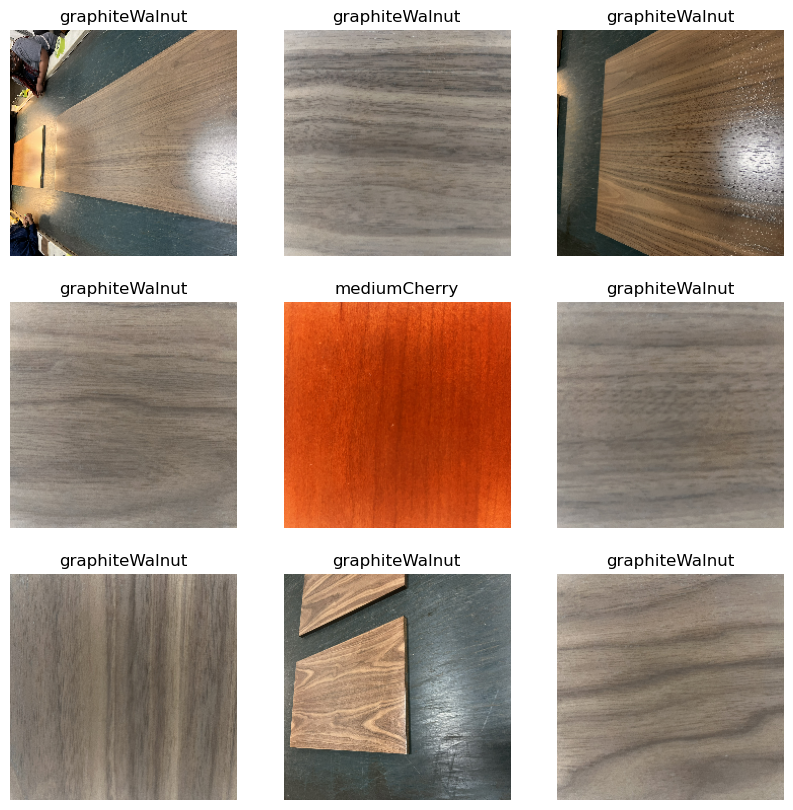

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
# Normalization Layer
normalization_layer = layers.Rescaling(1./255)

# Prepare Datasets
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [10]:
num_classes = len(class_names)

model = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

C:\Users\zuhai\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 853ms/step - accuracy: 0.8817 - loss: 0.3770 - val_accuracy: 0.9823 - val_loss: 0.0205
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.9931 - loss: 0.0312 - val_accuracy: 0.9912 - val_loss: 0.0083
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 727ms/step - accuracy: 0.9908 - loss: 0.0394 - val_accuracy: 0.9912 - val_loss: 0.0129
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.9922 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 1.4598e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 710ms/step - accuracy: 0.9997 - loss: 7.3534e-04 - val_accuracy: 1.0000 - val_loss: 4.1641e-06
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 5.4697e-04
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.9974 - loss: 0.0134 - val_accuracy: 0.9912 - val_loss: 0.0555
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 713ms/step - accuracy: 0.9938 - loss: 0

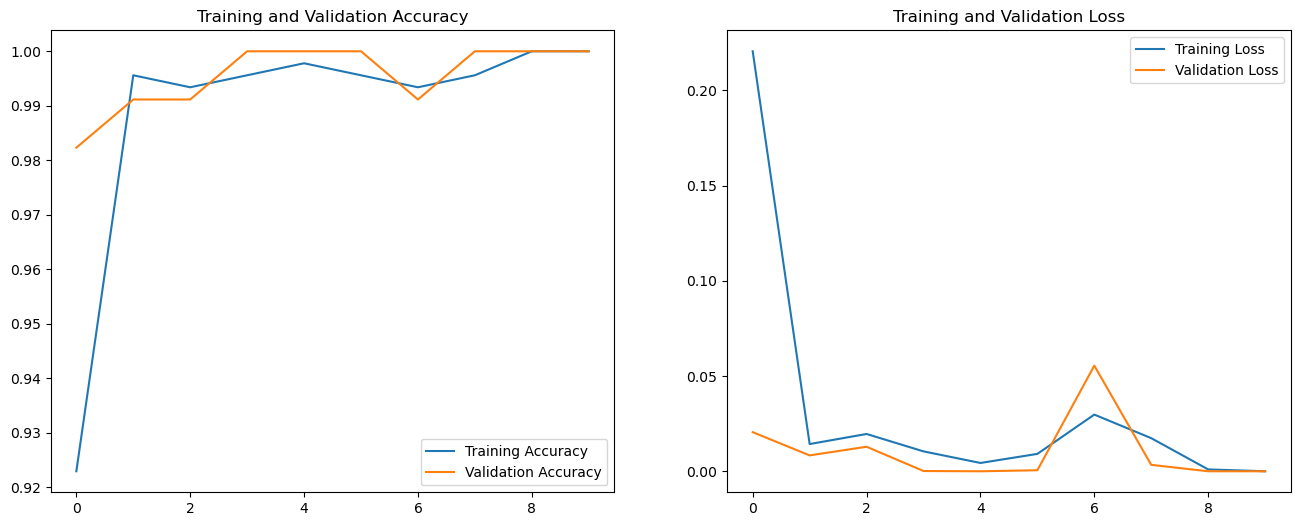

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 1.0000 - loss: 7.0779e-06
Validation Accuracy: 100.00%


In [15]:
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = normalization_layer(img_array)
    return img_array

In [21]:
image_path = 'IMG_3575.jpg'  # Replace with your image path
img_array = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)

print(f"This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
This image most likely belongs to graphiteWalnut with a 100.00% confidence.


In [22]:
model.save('color_detection_model.h5')

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('color_detection_model.h5')

# Define image dimensions (ensure these match your training image size)
img_height = 224  # Replace with your actual image height if different
img_width = 224   # Replace with your actual image width if different

# Define the class names (these should match the classes from your training dataset)
class_names = ['graphiteWalnut', 'mediumCherry']  # Replace with your class names

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image and resize it
    img = load_img(image_path, target_size=(img_height, img_width))
    # Convert the image to an array
    img_array = img_to_array(img)
    # Expand dimensions to match the model's input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image data
    img_array = img_array / 255.0  # Assuming the model expects normalized images
    return img_array

# Path to the test image (replace with your image filename)
image_path = 'IMG_1026.jpg'  # Ensure the image is in the same directory

# Load and preprocess the image
img_array = load_and_preprocess_image(image_path)

# Make a prediction
predictions = model.predict(img_array)
# Get the probability scores (if your model outputs logits)
probabilities = tf.nn.softmax(predictions[0])

# Get the predicted class and confidence
predicted_index = np.argmax(probabilities)
predicted_class = class_names[predicted_index]
confidence = probabilities[predicted_index] * 100

# Print the prediction result
print(f"This image most likely belongs to '{predicted_class}' with a {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
This image most likely belongs to 'mediumCherry' with a 100.00% confidence.
